<a href="https://colab.research.google.com/github/arpdm/predictive-maintenance-platform/blob/main/PdM_NASA_ENGINES_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources

https://github.com/mapr-demos/predictive-maintenance/blob/master/notebooks/jupyter/LSTM%20For%20Predictive%20Maintenance-ian01.ipynb

https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2

https://github.com/Azure/lstms_for_predictive_maintenance 
https://github.com/Azure-Samples/MachineLearningSamples-DeepLearningforPredictiveMaintenance/blob/master/Code/2_model_building_and_evaluation.ipynb

https://github.com/mapr-demos/predictive-maintenance/blob/master/notebooks/jupyter/LSTM%20For%20Predictive%20Maintenance-ian01.ipynb -- What we are using

https://www.kaggle.com/datasets/behrad3d/nasa-cmaps 
https://www.kaggle.com/code/scratchpad/notebook5cc58ab447/edit 


-- Notebook horizon with multiple cycles in advance
https://colab.research.google.com/drive/1SGsU5jyuJVodUwAhf3Budeyh7c-gHXOR?usp=sharing#scrollTo=mXTILGKqWks0 

==================== For learning rate scheduler =======================
https://colab.research.google.com/drive/1ceEa9Rs4BdGrfXfidwx-BpG-gtproWdQ#scrollTo=y6kJd40-0Hj9 


In [1]:
# Colab data file preparation
from google.colab import drive

drive.mount("/content/drive")

!cp drive/MyDrive/Predictive_Maintenence_Fault_Detection/predictive-maintenance-platform/data_processor.py .
!cp drive/MyDrive/Predictive_Maintenence_Fault_Detection/predictive-maintenance-platform/visualizer_analyzer.py .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from data_processor import DataProcessor
from visualizer_analyzer import DataAV

import tensorflow as tf

# Load all datasets
DS_001 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS01-005.h5"
DS_002 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS02-006.h5"
DS_003 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS03-012.h5"
DS_004 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS04.h5"
DS_005 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS05.h5"
DS_006 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS06.h5"
DS_007 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS07.h5"
DS_008 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08a-009.h5"
DS_009 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08c-008.h5"
DS_010 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08d-010.h5"

In [3]:
# Load data set and prepare data frames
pros = DataProcessor()
pros.load_hdf5_to_numpy_arr(DS_004)

Process data for NASA's engines run-to-failure datasets
Operation time (sec):  7.8216429839999995


In [4]:
# Prepare Data Frames

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_rul_train = pd.DataFrame(data=pros.y_rul_dev, columns=["RUL"])
df_rul_test = pd.DataFrame(data=pros.y_rul_test, columns=["RUL"])
df_x_s_train = pd.DataFrame(data=pros.x_s_dev, columns=pros.x_s_var_names)
df_x_s_test = pd.DataFrame(data=pros.x_s_test, columns=pros.x_s_var_names)
df_x_v_train = pd.DataFrame(data=pros.x_v_dev, columns=pros.x_v_var_names)
df_x_v_test = pd.DataFrame(data=pros.x_v_test, columns=pros.x_v_var_names)
df_aux_test = pd.DataFrame(data=pros.aux_test, columns=pros.aux_var_names)
df_aux_train = pd.DataFrame(data=pros.aux_dev, columns=pros.aux_var_names)
df_w_test = pd.DataFrame(data=pros.w_test, columns=pros.w_var_names)
df_w_train = pd.DataFrame(data=pros.w_dev, columns=pros.w_var_names)


In [5]:
df_x_s_train["cycle"] = df_aux_train["cycle"].values
df_x_s_train["RUL"] = df_rul_train.values
df_x_s_train["id"] = df_aux_train["unit"].values

df_x_s_test["cycle"] = df_aux_test["cycle"].values
df_x_s_test["RUL"] = df_rul_test.values
df_x_s_test["id"] = df_aux_test["unit"].values

In [ ]:
# Generate heatmap to figure out correlations between features and the RUL
# This helps to determine which features to drop and which features to keep
sns.heatmap(df_x_s_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [6]:
# Here, we will only make use of "label1" for binary clasification, while trying to answer the question: is a specific engine going to fail within w1 cycles?
# generate label columns for training data
import numpy as np

w1 = 30
w0 = 15
df_x_s_train['label1'] = np.where(df_x_s_train['RUL'] <= w1, 1, 0 )
df_x_s_train['label2'] = df_x_s_train['label1']
df_x_s_train.loc[df_x_s_train['RUL'] <= w0, 'label2'] = 2
df_x_s_train.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,cycle,RUL,id,label1,label2
0,620.536686,1500.497778,1918.887446,1305.895297,19.186726,13.769427,19.462331,24.474988,420.022739,426.578936,16.312785,2229.036206,8790.661678,5.117880,1.0,86,1.0,0,0
1,620.212233,1501.026264,1918.174792,1306.704845,19.168470,13.765780,19.472561,24.482789,419.831067,426.528828,16.314777,2229.338301,8790.557024,5.113072,1.0,86,1.0,0,0
2,620.691023,1501.435624,1917.553771,1305.988738,19.161991,13.768780,19.459324,24.487983,419.814866,426.332878,16.303461,2227.314527,8793.731801,5.113295,1.0,86,1.0,0,0
3,620.355416,1500.911321,1917.426968,1305.531529,19.171850,13.754179,19.460298,24.493184,419.747243,426.108069,16.310728,2227.793004,8792.134355,5.112996,1.0,86,1.0,0,0
4,620.591359,1501.437449,1918.752200,1305.696191,19.161257,13.744312,19.455585,24.458775,419.775992,426.066808,16.285185,2228.217157,8796.438082,5.109202,1.0,86,1.0,0,0


In [7]:
# Normalize Data
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle column. Here, we normalize the columns in the training data.
# MinMax normalization
from sklearn import preprocessing

df_x_s_train['cycle_norm'] = df_x_s_train['cycle']
cols_normalize = df_x_s_train.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_x_s_train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_x_s_train.index)
join_df = df_x_s_train[df_x_s_train.columns.difference(cols_normalize)].join(norm_train_df)
df_x_s_train = join_df.reindex(columns = df_x_s_train.columns)
df_x_s_train.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,cycle,RUL,id,label1,label2,cycle_norm
0,0.913485,0.926441,0.943923,0.931812,0.921720,0.830940,0.920594,0.907642,0.911067,0.911286,0.963790,0.922064,0.929397,0.904094,1.0,86,1.0,0,0,0.0
1,0.911325,0.927555,0.943249,0.933022,0.920462,0.830618,0.921289,0.908043,0.910557,0.911154,0.963948,0.922431,0.929329,0.903193,1.0,86,1.0,0,0,0.0
2,0.914513,0.928418,0.942661,0.931952,0.920015,0.830883,0.920390,0.908310,0.910514,0.910640,0.963055,0.919974,0.931365,0.903234,1.0,86,1.0,0,0,0.0
3,0.912278,0.927313,0.942541,0.931269,0.920695,0.829592,0.920456,0.908577,0.910334,0.910050,0.963628,0.920555,0.930341,0.903178,1.0,86,1.0,0,0,0.0
4,0.913849,0.928422,0.943795,0.931515,0.919964,0.828719,0.920136,0.906809,0.910410,0.909941,0.961613,0.921070,0.933101,0.902467,1.0,86,1.0,0,0,0.0


In [8]:
# generate label columns w0 and w1 for test data
df_x_s_test['label1'] = np.where(df_x_s_test['RUL'] <= w1, 1, 0 )
df_x_s_test['label2'] = df_x_s_test['label1']
df_x_s_test.loc[df_x_s_test['RUL'] <= w0, 'label2'] = 2
df_x_s_test.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,cycle,RUL,id,label1,label2
0,620.506639,1488.080832,1886.473168,1287.156838,19.372008,14.154111,19.676307,24.547359,409.284230,415.810164,16.163146,2188.171877,8751.322228,4.890535,1.0,86,7.0,0,0
1,620.478004,1487.467210,1885.286698,1288.280169,19.363287,14.156930,19.664207,24.537576,408.996413,415.692275,16.159712,2187.423272,8743.692986,4.888862,1.0,86,7.0,0,0
2,619.526099,1487.808291,1884.016137,1287.319699,19.350864,14.150683,19.643745,24.533771,408.775613,415.401764,16.158847,2188.468300,8753.865949,4.884320,1.0,86,7.0,0,0
3,620.244129,1488.433841,1885.296970,1288.064834,19.348055,14.150770,19.653264,24.530714,408.948377,415.447424,16.155031,2186.216852,8750.814968,4.886681,1.0,86,7.0,0,0
4,619.971242,1487.979131,1885.384862,1286.838059,19.345743,14.153215,19.638651,24.540065,408.531735,415.402249,16.152368,2187.986398,8745.387650,4.884689,1.0,86,7.0,0,0


In [12]:
df_x_s_test['cycle_norm'] = df_x_s_test['cycle']
cols_normalize = df_x_s_test.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df_x_s_test[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_x_s_test.index)
join_df = df_x_s_test[df_x_s_test.columns.difference(cols_normalize)].join(norm_df)
df_x_s_test = join_df.reindex(columns = df_x_s_test.columns)
df_x_s_test.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,cycle,RUL,id,label1,label2,cycle_norm
0,0.917816,0.904795,0.915938,0.899385,0.941962,0.854654,0.942960,0.924487,0.894875,0.895331,0.953202,0.882191,0.907219,0.866471,1.0,86,7.0,0,0,0.0
1,0.917600,0.903490,0.914817,0.901040,0.941302,0.854919,0.942058,0.923932,0.894096,0.895015,0.952915,0.881275,0.902226,0.866156,1.0,86,7.0,0,0,0.0
2,0.910399,0.904216,0.913617,0.899625,0.940362,0.854332,0.940533,0.923717,0.893499,0.894235,0.952842,0.882554,0.908884,0.865301,1.0,86,7.0,0,0,0.0
3,0.915830,0.905546,0.914827,0.900723,0.940150,0.854340,0.941242,0.923543,0.893966,0.894358,0.952523,0.879798,0.906887,0.865745,1.0,86,7.0,0,0,0.0
4,0.913766,0.904579,0.914910,0.898915,0.939975,0.854570,0.940153,0.924073,0.892839,0.894236,0.952301,0.881964,0.903335,0.865370,1.0,86,7.0,0,0,0.0


# Modeling

The traditional predictive maintenance machine learning models are based on feature engineering which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenario and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering.

he idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

One critical advantage of LSTMs is their ability to remember from long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. For example, computing rolling averages over a window size of 50 cycles may lead to loss of information due to smoothing and abstracting of values over such a long period, instead, using all 50 values as input may provide better results. While feature engineering over large window sizes may not make sense, LSTMs are able to use larger window sizes and use all the information in the window as input. 
LSTM also has this long term memory over regular RNN architectecture.

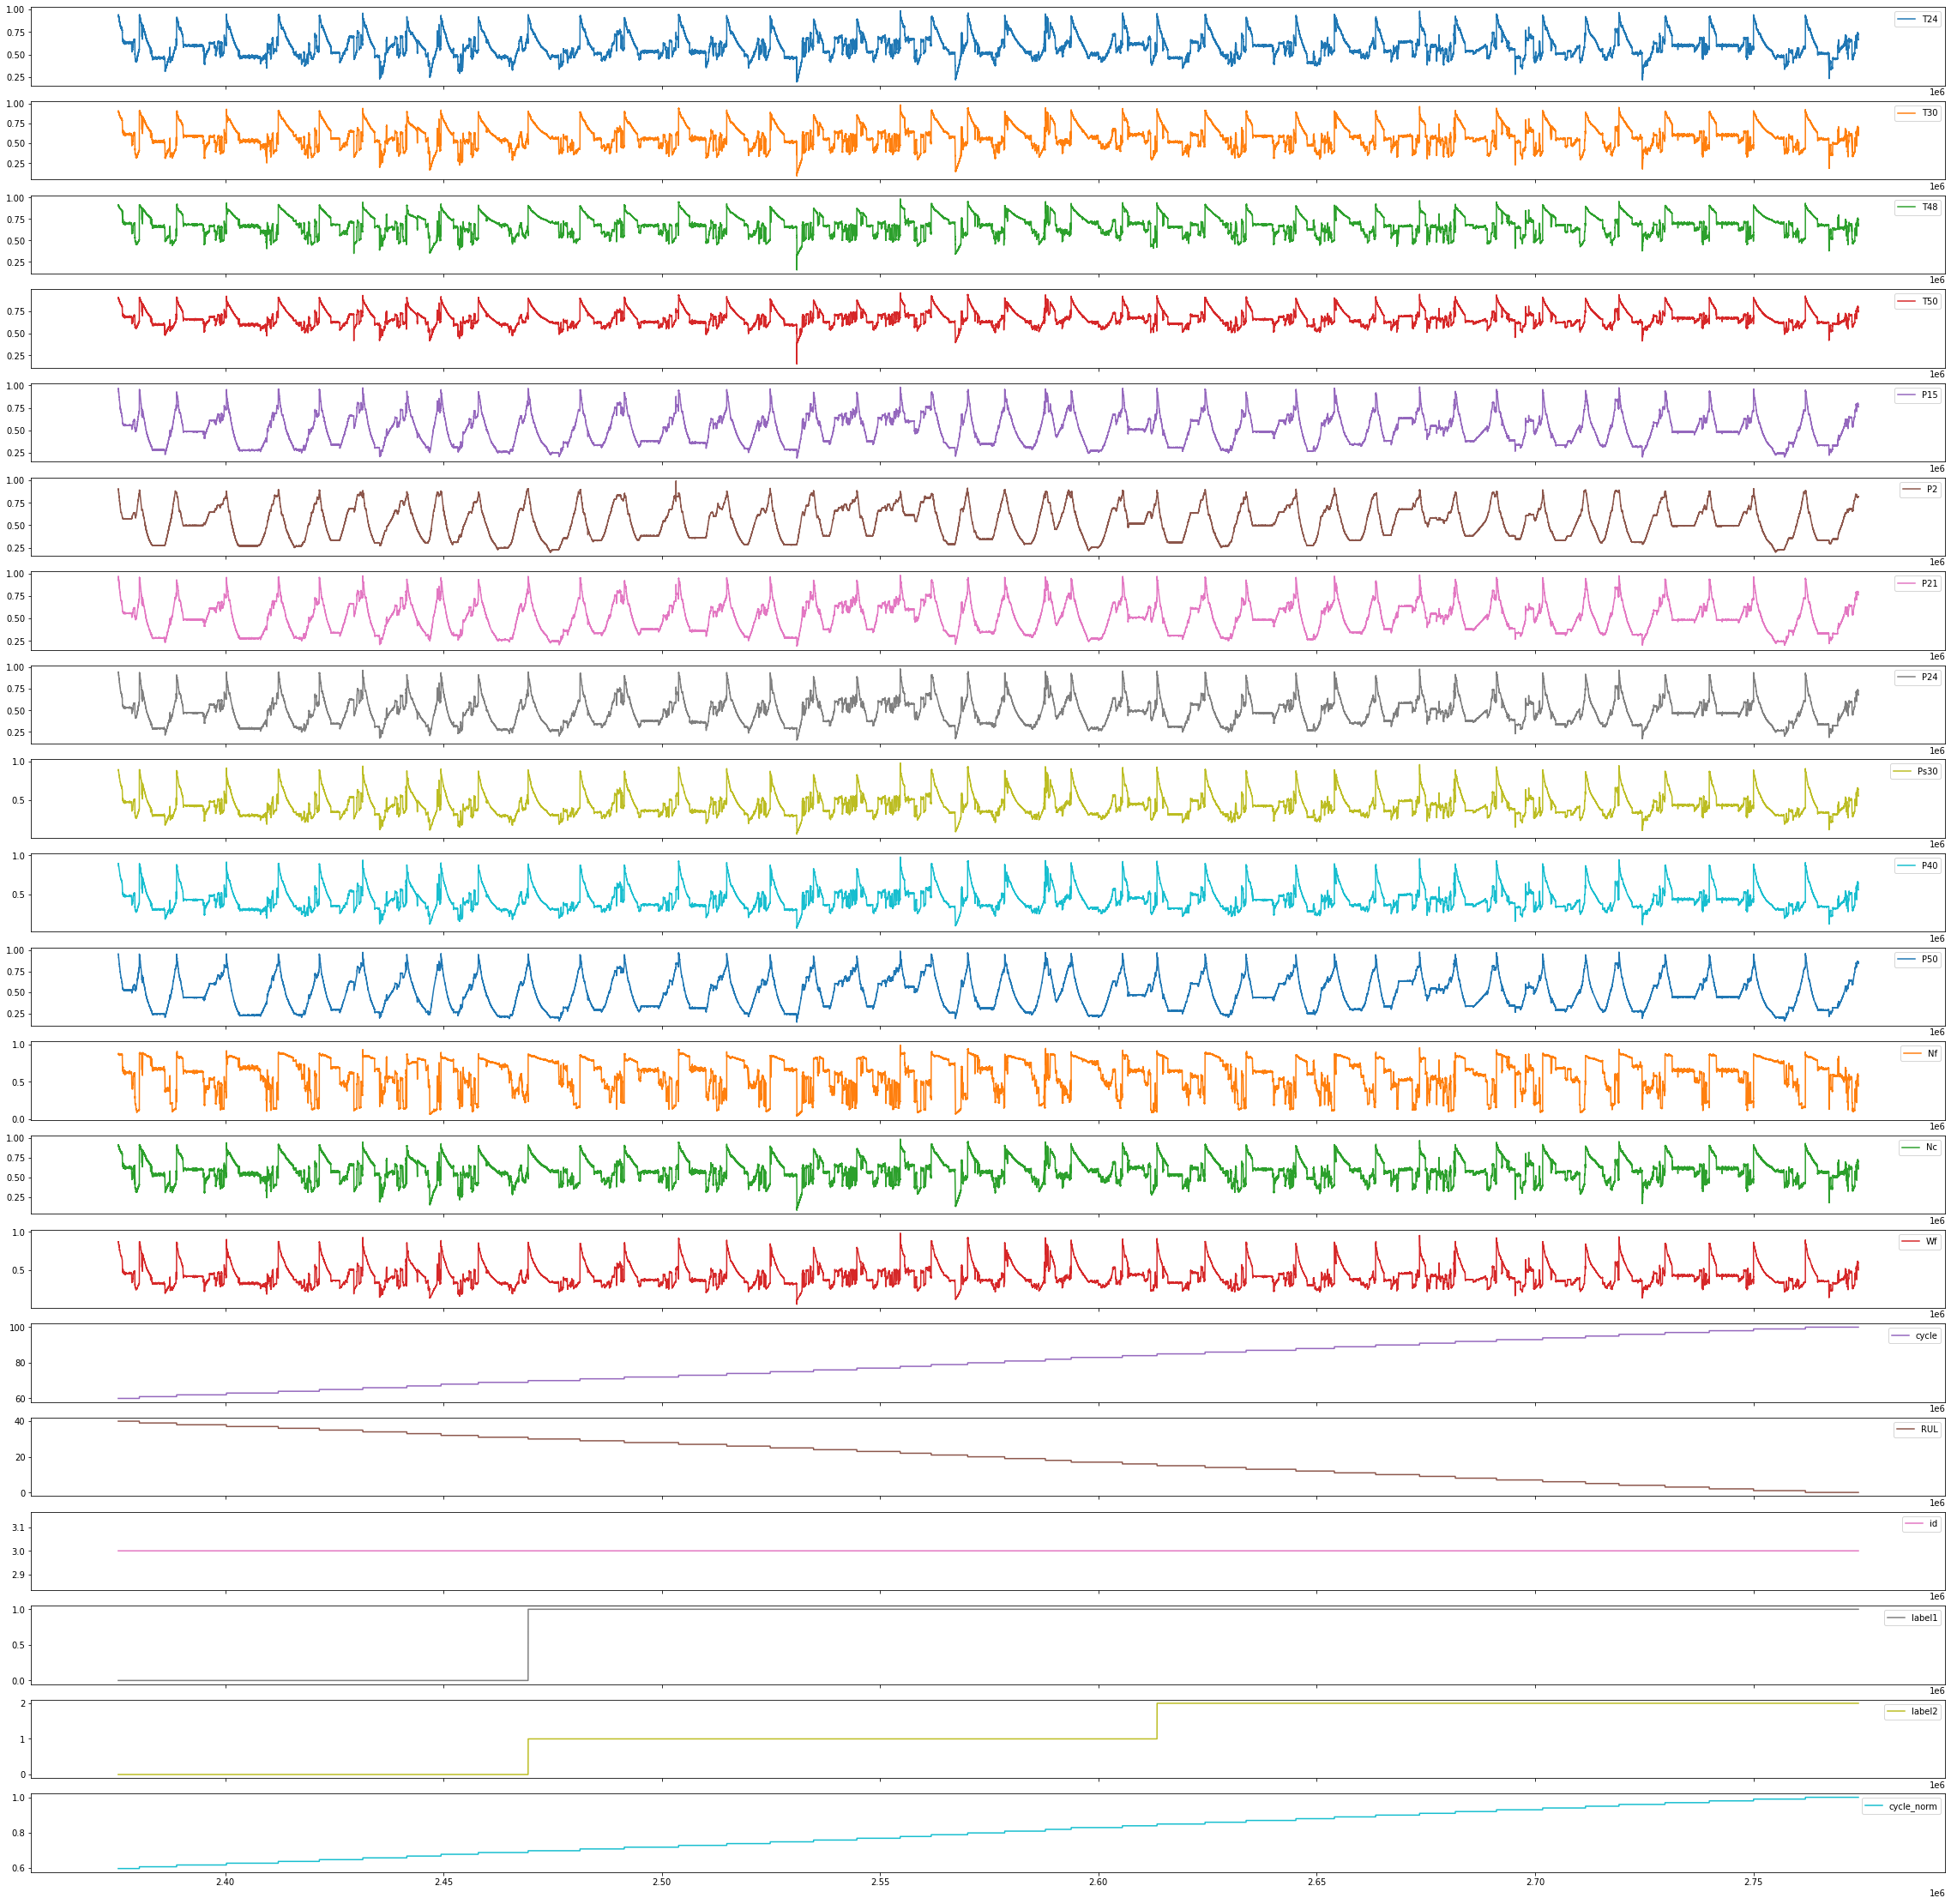

In [13]:
"""
Genearate the tf dataset with proper dimensionality and shape given input parameters.
This dataset will split into training and validation subsets.
"""

window = 40
horizon = 5
train_split = 6377452
batch_size = 256
buffer_size = 150

# Let's first look at an example of the sensor values 50 cycles prior to the failure for engine id 3. 
# We will be feeding LSTM network this type of data for each time step for each engine id.

# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = df_x_s_train[df_x_s_train['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + window]


ax1 = engine_id3_50cycleWindow.plot(subplots=True, sharex=True, figsize=(40,40))

## Data Sequence Generation for Model

Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.


In [14]:
engine_id3_x_train = engine_id3[engine_id3.columns]
engine_id3_y_train = engine_id3_x_train.filter(['RUL','label1','label2'])
engine_id3_x_train = engine_id3_x_train.drop(columns=['RUL','label1','label2','cycle','id'])
engine_id3_x_train.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,cycle_norm
1850114,0.914584,0.883150,0.896643,0.886916,0.952728,0.898712,0.953337,0.923639,0.869369,0.870778,0.948600,0.844169,0.889870,0.839796,0.0
1850115,0.916763,0.885236,0.894889,0.888686,0.953230,0.900214,0.953186,0.924318,0.869921,0.869818,0.946715,0.842411,0.884890,0.839812,0.0
1850116,0.917570,0.884277,0.895584,0.888107,0.952955,0.898417,0.953554,0.922579,0.870254,0.870531,0.946957,0.843673,0.881168,0.839666,0.0
1850117,0.916589,0.887885,0.897515,0.888322,0.953375,0.898723,0.953653,0.923785,0.871091,0.872110,0.947803,0.846593,0.888079,0.842107,0.0
1850118,0.916814,0.887047,0.896089,0.889045,0.954075,0.900016,0.954268,0.924580,0.870415,0.872364,0.947341,0.847696,0.887888,0.841340,0.0


In [15]:
engine_id3_test = df_x_s_test[df_x_s_test['id'] == 7]
engine_id3_y_test = engine_id3_test.filter(['RUL','label1','label2'])
engine_id3_x_test = engine_id3_test.drop(columns=['RUL','label1','label2','cycle','id'])
engine_id3_x_test.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,cycle_norm
0,0.917816,0.904795,0.915938,0.899385,0.941962,0.854654,0.942960,0.924487,0.894875,0.895331,0.953202,0.882191,0.907219,0.866471,0.0
1,0.917600,0.903490,0.914817,0.901040,0.941302,0.854919,0.942058,0.923932,0.894096,0.895015,0.952915,0.881275,0.902226,0.866156,0.0
2,0.910399,0.904216,0.913617,0.899625,0.940362,0.854332,0.940533,0.923717,0.893499,0.894235,0.952842,0.882554,0.908884,0.865301,0.0
3,0.915830,0.905546,0.914827,0.900723,0.940150,0.854340,0.941242,0.923543,0.893966,0.894358,0.952523,0.879798,0.906887,0.865745,0.0
4,0.913766,0.904579,0.914910,0.898915,0.939975,0.854570,0.940153,0.924073,0.892839,0.894236,0.952301,0.881964,0.903335,0.865370,0.0


In [16]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols, label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)



In [17]:
# generate X_train
X_train=np.array(list(gen_sequence(engine_id3_x_train, window, engine_id3_x_train.columns)))
print(X_train.shape)

(923936, 40, 15)


In [21]:
# generate y_train
y_train=np.array(list(gen_label(engine_id3_y_train, window, engine_id3_y_train.columns,'label1')))
print(y_train.shape)

(923936,)


## LSTM Model Architecture - Binary Classification


=========== We want to see if the engine will fail witing provided cycles
* We like LSTM because it has long-term memory, which we need for predicing rare time series events
* We add Dropout because it helps reduce overfitting by randomly dropping neurons. This helps improves accuracy and forces neurons to generalize better.
We add Sigmoid function so the output of neurons is either 0 or 1. And we apply the Sigmoid with 
* the Dense function so it gets applied to every neuron (i.e. as a fully connected layer).
* We must specify a loss function and an optimizer function when compiling the model.
The loss function is a way of penalizing the model for low accuracy scores. We use binary cross entropy because we have just two classes (1 and 0).
* The optimizer defines how to adjust neuron weights in response to inaccuracate predictions. The Adam optimizer make sense, because I’ve read that Adam learns fast, is stable over a wide range of learning rates, and has comparatively low memory requirements. Keras uses a default learning rate of 0.001.





In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

features = X_train.shape[2]

mark_001 = Sequential()
mark_001.add(LSTM(
         input_shape=(window, features),
         units=100,
         return_sequences=True))
mark_001.add(Dropout(0.2))

mark_001.add(LSTM(
          units=50,
          return_sequences=False))
mark_001.add(Dropout(0.2))

mark_001.add(Dense(units=1, activation='sigmoid'))
mark_001.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mark_001.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 40, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 76,651
Trainable params: 76,651
Non-trainable params: 0
_________________________________________________________________


In [28]:
from keras.callbacks import EarlyStopping
import keras

## Fit the model - Mark 001
epochs = 40
steps = 100

history = mark_001.fit(X_train, y_train, epochs=epochs,steps_per_epoch=steps, batch_size=10, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
          )

# list all data in history
print(history.history.keys())

Epoch 1/40
100/100 [==============================] - 16s 164ms/step - loss: 0.0546 - accuracy: 0.9740 - val_loss: 2.6154e-05 - val_accuracy: 1.0000
Epoch 2/40
100/100 [==============================] - 16s 157ms/step - loss: 0.0331 - accuracy: 0.9860 - val_loss: 1.1151e-05 - val_accuracy: 1.0000
Epoch 3/40
100/100 [==============================] - 15s 156ms/step - loss: 0.0647 - accuracy: 0.9760 - val_loss: 5.1071e-04 - val_accuracy: 1.0000
Epoch 4/40
100/100 [==============================] - 15s 155ms/step - loss: 0.0513 - accuracy: 0.9790 - val_loss: 1.9872e-04 - val_accuracy: 1.0000
Epoch 5/40
100/100 [==============================] - 15s 155ms/step - loss: 0.0415 - accuracy: 0.9810 - val_loss: 9.2437e-06 - val_accuracy: 1.0000
Epoch 6/40
100/100 [==============================] - 15s 154ms/step - loss: 0.0397 - accuracy: 0.9840 - val_loss: 8.3737e-05 - val_accuracy: 1.0000
Epoch 7/40
100/100 [==============================] - 15s 155ms/step - loss: 0.0628 - accuracy: 0.9770 - v

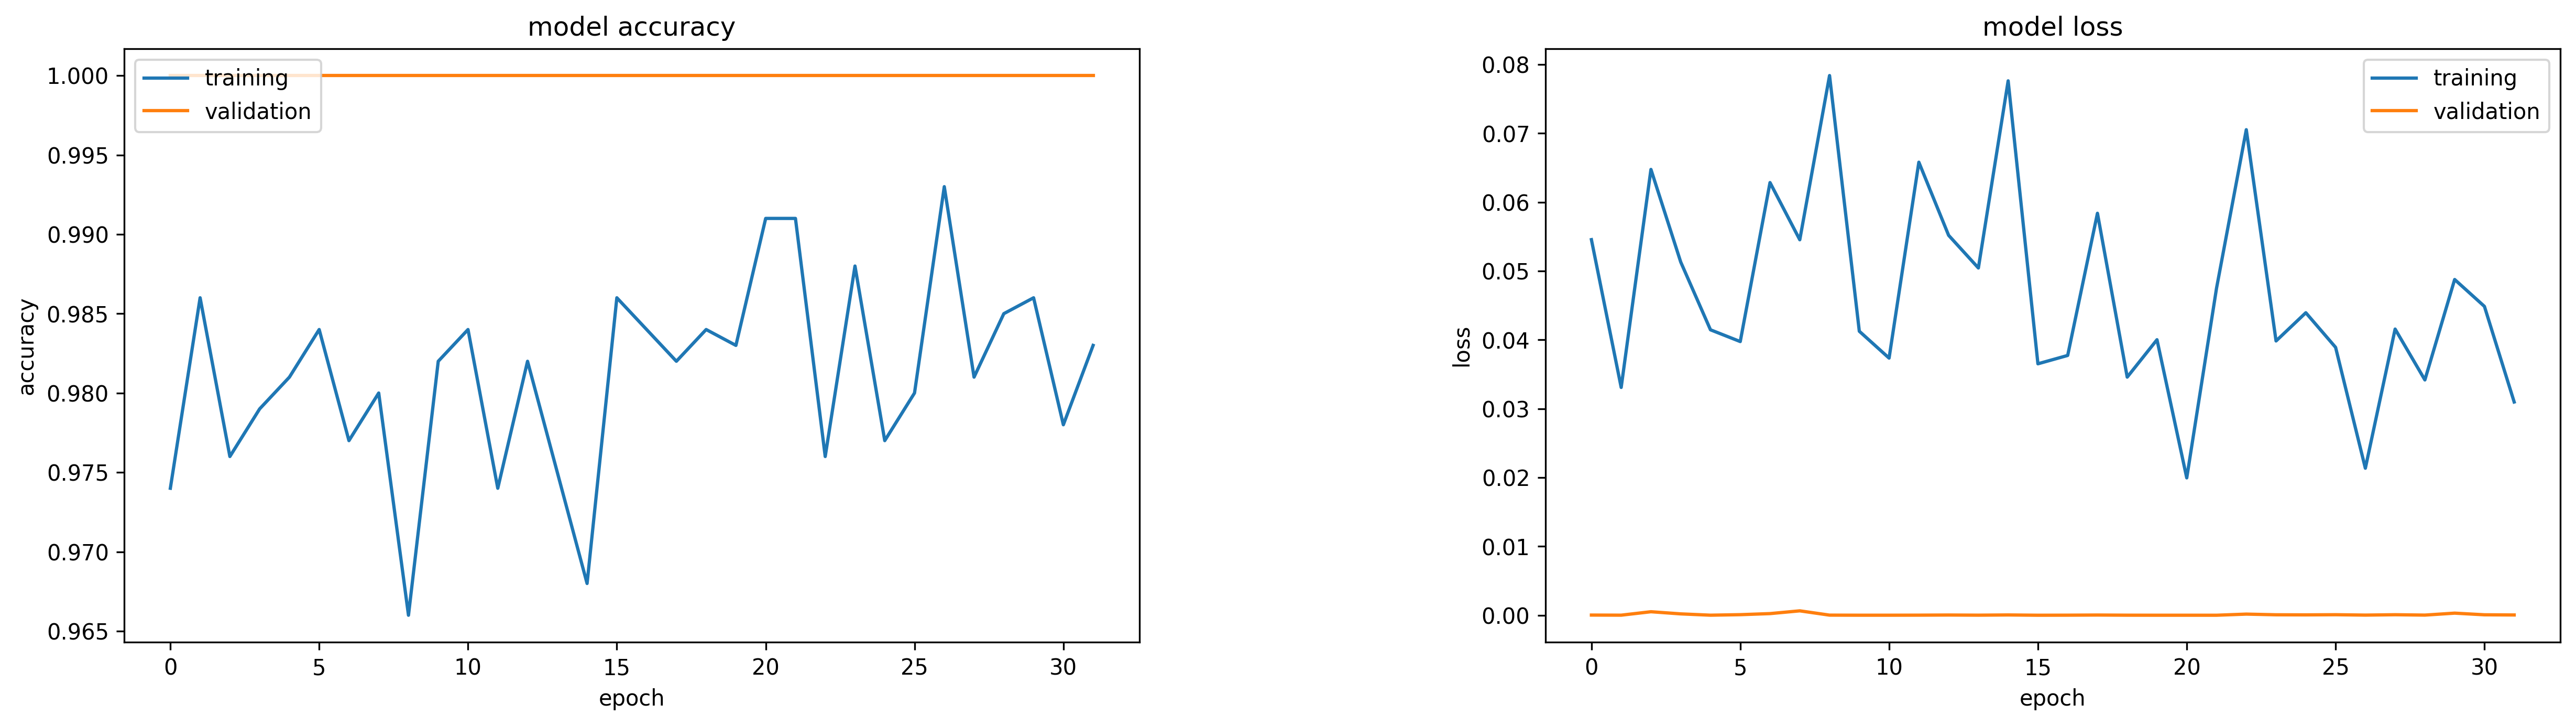

In [30]:
MARK_001_Data = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/mark_001"

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(20, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend(['training', 'validation'], loc='upper left')

# summarize history for Loss
plt.subplot(1, 2, 2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(['training', 'validation'], loc='upper right')
# plt.show()
fig_acc.savefig(f"{MARK_001_Data}/model_loss.png")

In [ ]:
############## SAVE MODEL
##################################
# Save model and training history
##################################

import pickle
filename = open("./Output/LSTM_about_to_fail_model_history","wb")
pickle.dump(history, filename)
filename.close()
        
# serialize model to JSON
model_json = model.to_json()
with open("./Output/LSTM_about_to_fail_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./Output/LSTM_about_to_fail_model.h5")
print("Saved model to disk")

In [ ]:
###########################################
# Load model and training history from disk
###########################################
import pickle
history_file = open("./Output/LSTM_about_to_fail_model_history","rb")
history = pickle.load(history_file)
history_file.close()

# Load model from disk
from keras.models import model_from_json
# load json and create model
json_file = open("./Output/LSTM_about_to_fail_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("./Output/LSTM_about_to_fail_model.h5")
print("Loaded model from disk")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Evaluation and Predictions

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# make predictions and compute confusion matrix
scores = mark_001.evaluate(X_train, y_train, verbose=1, batch_size=200)
# since it is a classification, we want to predicat classes - predict_classes is depricated so we are gonna convert to in32 if above 0.5
y_pred = (mark_001.predict(X_train, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = y_train

print('Accuracy of predictions made on data used for training:\n{}'.format(scores[1]))

# compute precision and recall
recall = recall_score(y_true, y_pred)
print('\nrecall = ' + str(recall))

4620/4620 [==============================] - 18s 4ms/step
Accuracy of predictions made on data used for training:
0.9801490306854248

recall = 1.0


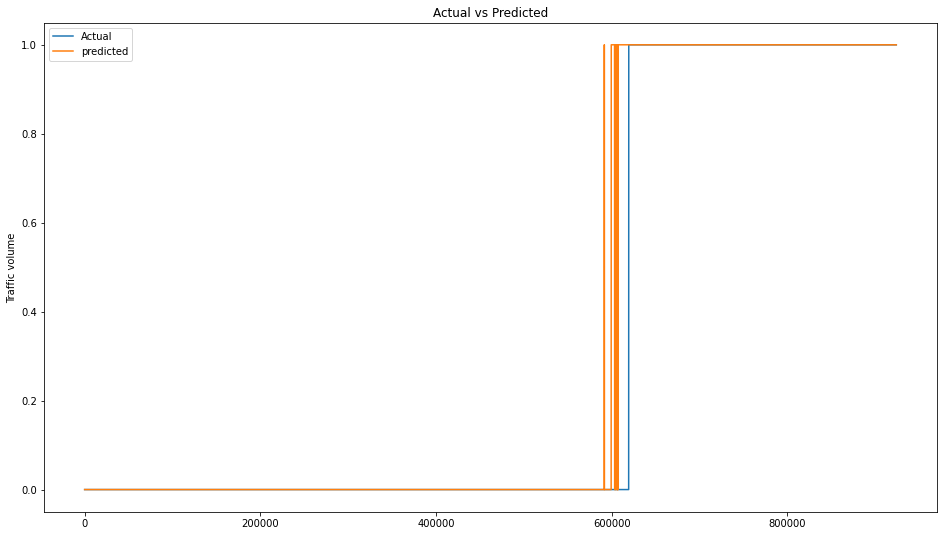

In [37]:
# summarize history for Loss

plt.figure(figsize=(16,9))
plt.plot( list(y_true.reshape(-1)))
plt.plot( list(y_pred.reshape(-1)))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

In [40]:
test_mae_loss = np.mean(np.abs(y_pred.reshape(1,-1) - y_true.reshape(1,-1)), axis=1)
test_mae_loss

array([0.01985094])

In [41]:
print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm).head(2)

Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels


,0,1
0,600931,18341
1,0,304664


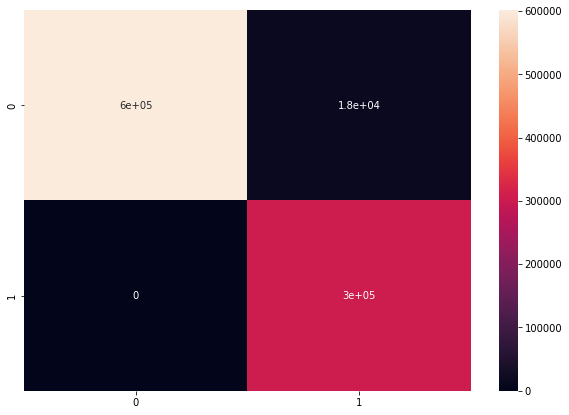

In [43]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(pd.DataFrame(cm), annot=True)

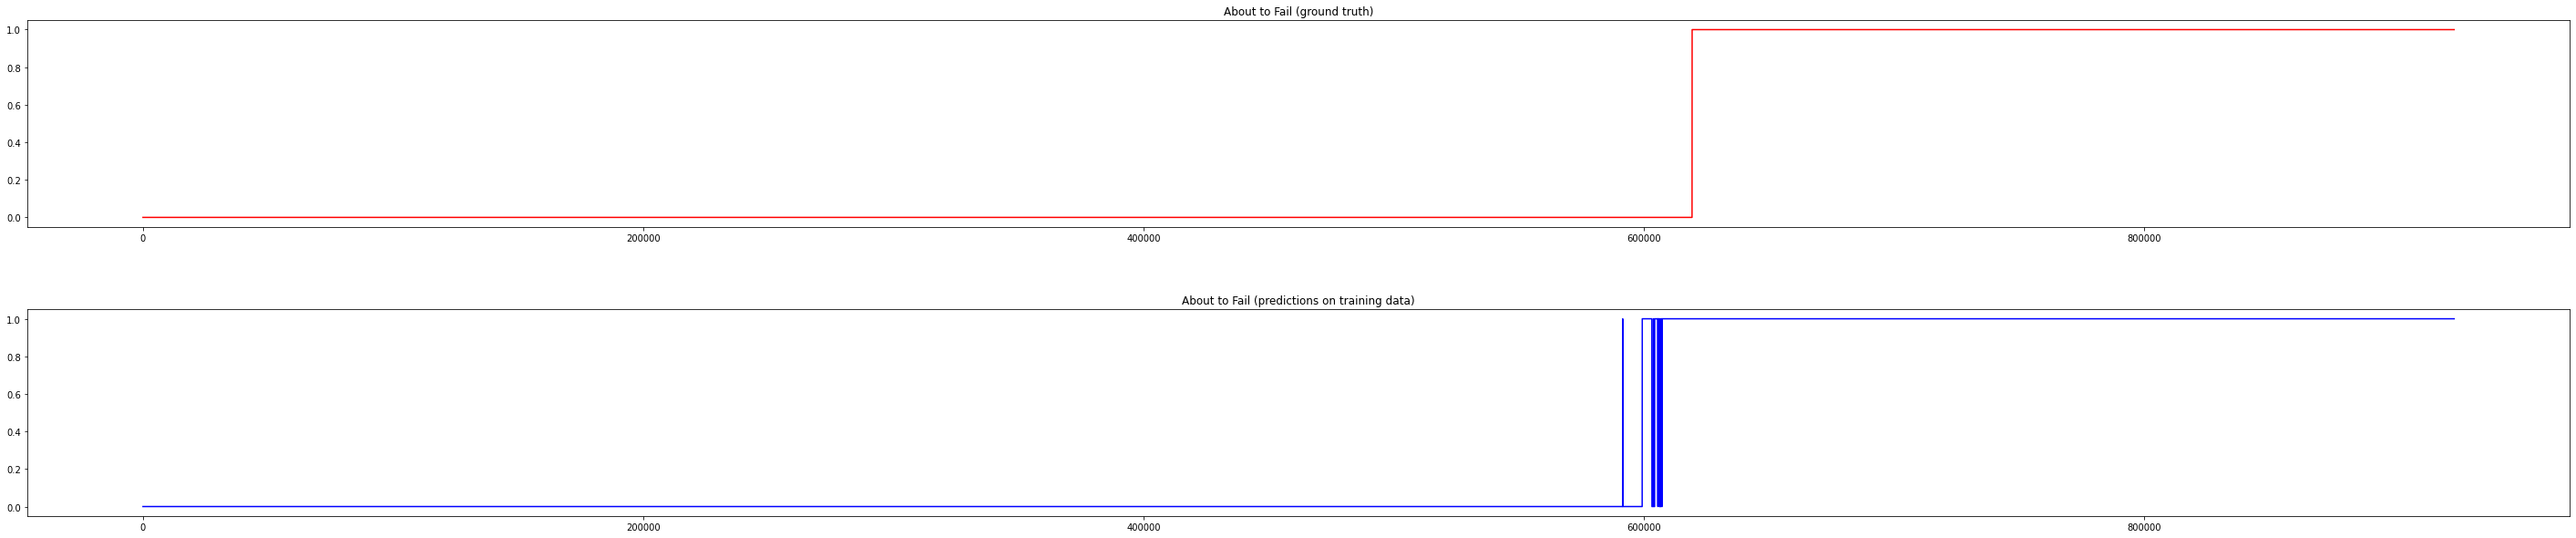

In [44]:
plt.figure(figsize=(50, 10))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (ground truth)")
plt.plot(y_true,'r')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (predictions on training data)")
plt.plot(y_pred,'b')

## Prediction with test data


In [50]:
engine_id3_test = df_x_s_test[df_x_s_test['id'] == 8]
engine_id3_y_test = engine_id3_test.filter(['RUL','label1','label2'])
engine_id3_x_test = engine_id3_test.drop(columns=['RUL','label1','label2','cycle','id'])
engine_id3_x_test.head()

X_test_2 = np.array(list(gen_sequence(engine_id3_x_test, window, engine_id3_x_test.columns)))
print(X_train.shape)

y_test_2 = np.array(list(gen_label(engine_id3_y_test, window, engine_id3_y_test.columns,'label1')))

y_pred2 = (mark_001.predict(X_test_2) > 0.5).astype("int32")
print('Accuracy of model on test data: ' + str(accuracy_score(y_test_2,y_pred2)))
pd.DataFrame(confusion_matrix(y_test_2,y_pred2)).head(2)

y_true_2 = y_test_2

# compute precision and recall
recall = recall_score(y_true_2, y_pred2)
print('\nrecall = ' + str(recall))

(923936, 40, 15)
26800/26800 [==============================] - 86s 3ms/step
Accuracy of model on test data: 0.9825313202548531

recall = 1.0


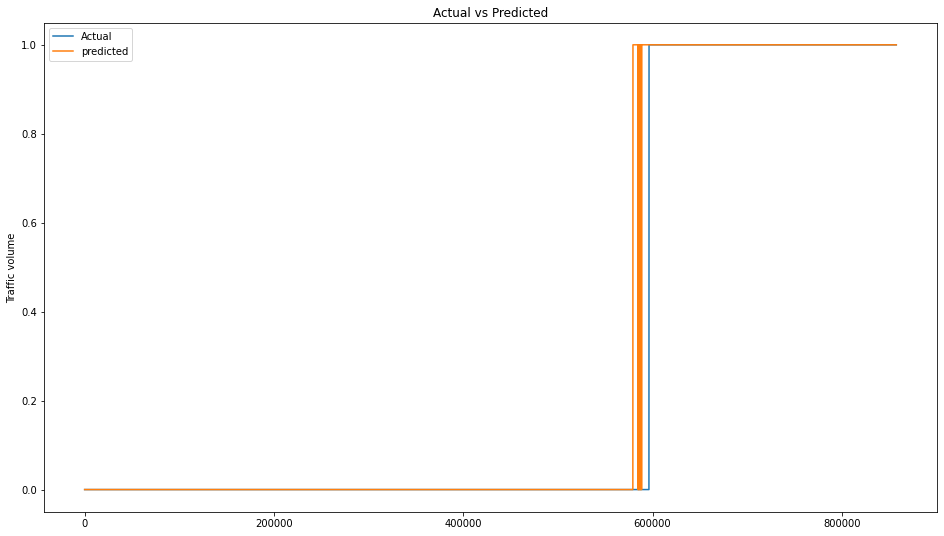

Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels


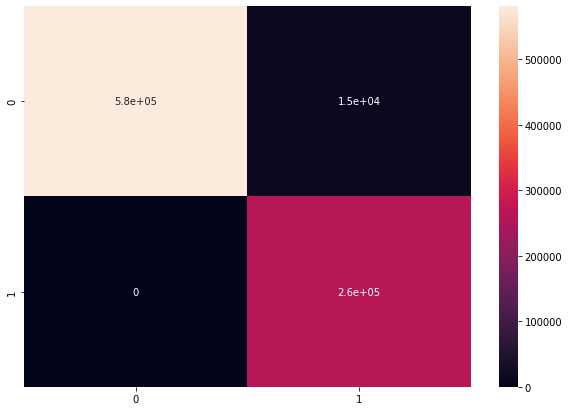

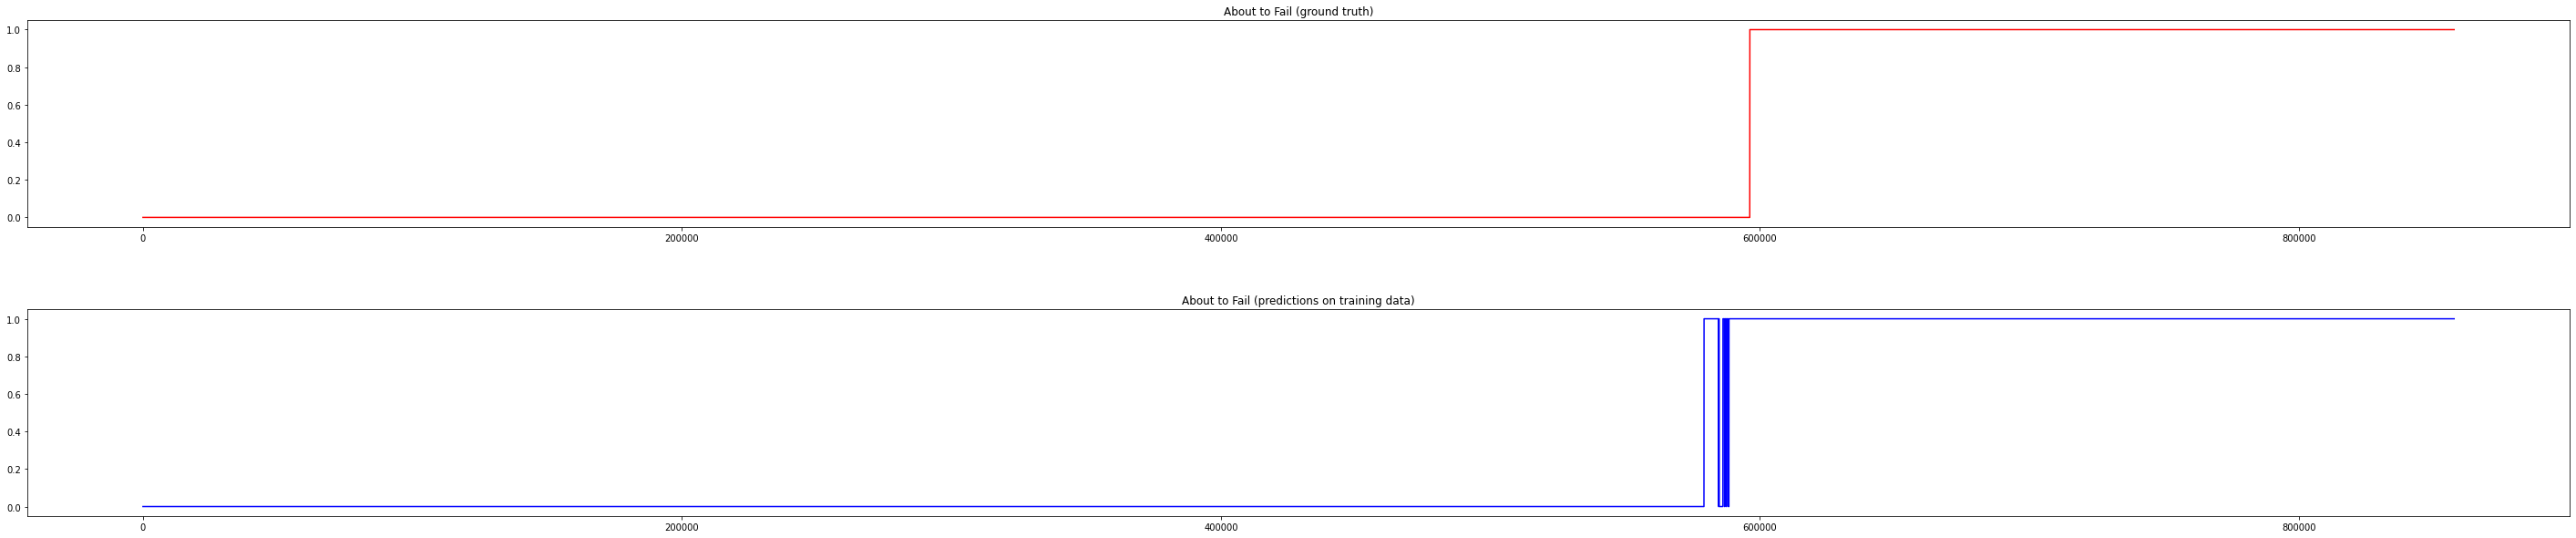

In [51]:

plt.figure(figsize=(16,9))
plt.plot( list(y_true_2.reshape(-1)))
plt.plot( list(y_pred2.reshape(-1)))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

test_mae_loss = np.mean(np.abs(y_pred2.reshape(1,-1) - y_true_2.reshape(1,-1)), axis=1)
test_mae_loss

print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_2, y_pred2)
pd.DataFrame(cm).head(2)

plt.figure(figsize = (10,7))
sn.heatmap(pd.DataFrame(cm), annot=True)

plt.figure(figsize=(50, 10))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (ground truth)")
plt.plot(y_true_2,'r')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (predictions on training data)")
plt.plot(y_pred2,'b')

In [ ]:
def prob_failure(df):
    test = gen_sequence(df,seq_length,seq_cols)
    m_pred = model.predict(test)
    failure_prob=list(m_pred[-1])[0]
    return failure_prob

def plot_prediction(df):
    X_test3=np.array(list(gen_sequence(df, seq_length, seq_cols)))
    y_test3=np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
    y_pred3=model.predict_classes(X_test3)
    confidence = model.predict(gen_sequence(df,seq_length,seq_cols))
    plt.figure(figsize=(20, 10), dpi=300)
    plt.subplot(4, 4, 1)
    plt.subplots_adjust(hspace=.4, wspace=.4)
    plt.title("About to Fail Within "+str(about_to_fail_window)+" cycles")
    plt.ylim(-.1, 1.1)
    plt.xlabel('cycles')
    plt.yticks(np.arange(2), ('False', 'True'))
    plt.plot(df['about_to_fail'], 'r', label='actual')
    plt.plot(y_pred3, 'b', label='predicted')
    plt.legend(loc='upper left')
    plt.subplot(4, 4, 2)
    plt.title("Probability of Failure")
    plt.ylim(-.1, 1.1)
    plt.xlabel('cycles')
    plt.plot(confidence,'r')
    print "Probability of failure within " + str(about_to_fail_window) + " cycles: {0:.1%}".format(prob_failure(df))
    print('Accuracy Score: {0:.2}'.format(accuracy_score(y_test3,y_pred3)))
    print('Confusion matrix:\n- x-axis is true labels.\n- y-axis is predicted labels')
    print(pd.DataFrame(confusion_matrix(y_test3,y_pred3)).head(2))


df=pd.read_json('PM3/PM_logsynth_test1.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

